In [1]:
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit, Aer, assemble
from qiskit import execute

In [2]:
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

In [3]:
# load account

In [4]:
IBMQ.save_account('ead46a48725b88f872e47c38c4ddc51a5f73c1573ea658477dcd2bee0989e682d0c607ef3f4b19345be56e64669a512a2655132b1c3c06c0a54ed79c724c554d', overwrite=True)

In [5]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [6]:
provider = IBMQ.get_provider(hub='ibm-q')

In [7]:
device = provider.get_backend('ibmq_quito')

In [8]:
device

<IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>

In [9]:
# simple circuit

In [10]:
qc_output = QuantumCircuit(2, 2)

In [11]:
for j in range(2):
    qc_output.measure(j,j)

In [12]:
qc_output.draw()

┌─┐   
q_0: ┤M├───
     └╥┘┌─┐
q_1: ─╫─┤M├
      ║ └╥┘
c: 2/═╩══╩═
      0  1

In [ ]:
# Classic simulator

In [ ]:
sim = Aer.get_backend('aer_simulator')  # this is the simulator we'll use
qobj = assemble(qc_output)  # this turns the circuit into an object our backend can run
result = sim.run(qobj).result()  # we run the experiment and get the result from that experiment
# from the results, we get a dictionary containing the number of times (counts)
# each result appeared
counts = result.get_counts()
# and display it on a histogram
plot_histogram(counts)

In [ ]:
counts

In [ ]:
# Real quantum

In [13]:
job = execute(qc_output, backend=device, shots=100)

In [14]:
print(job.job_id())

6158c519ceec1bd88c6f8d89


In [15]:
job_monitor(job)

Job Status: job has successfully run


In [16]:
device_result = job.result()

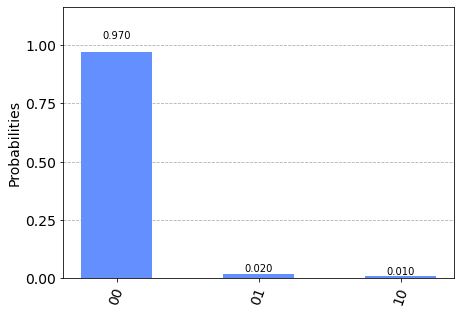

In [17]:
plot_histogram(device_result.get_counts(qc_output))

In [27]:
# add two single qbits

In [18]:
qc_add_single = QuantumCircuit(4, 2)

In [19]:
qc_add_single.x(0)
qc_add_single.barrier()

In [20]:
qc_add_single.cx(0, 2)
qc_add_single.cx(1, 2)
qc_add_single.ccx(0, 1, 3)
qc_add_single.barrier()

In [21]:
qc_add_single.measure(2, 0)
qc_add_single.measure(3, 1)

In [22]:
qc_add_single.draw()

┌───┐ ░                 ░       
q_0: ┤ X ├─░───■─────────■───░───────
     └───┘ ░   │         │   ░       
q_1: ──────░───┼────■────■───░───────
           ░ ┌─┴─┐┌─┴─┐  │   ░ ┌─┐   
q_2: ──────░─┤ X ├┤ X ├──┼───░─┤M├───
           ░ └───┘└───┘┌─┴─┐ ░ └╥┘┌─┐
q_3: ──────░───────────┤ X ├─░──╫─┤M├
           ░           └───┘ ░  ║ └╥┘
c: 2/═══════════════════════════╩══╩═
                                0  1

In [23]:
n_shots = 100

In [25]:
job = execute(qc_add_single, backend=device, shots=n_shots)

In [26]:
job_monitor(job)

Job Status: job has successfully run


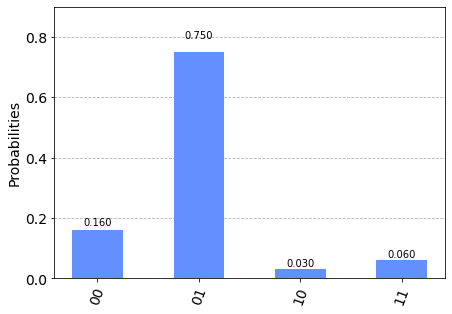

In [28]:
device_result = job.result()
plot_histogram(device_result.get_counts(qc_add_single))

In [ ]:
n1 = '1'
n2 = '1'

In [ ]:
n = len(n1)

# Initializing the registers; two quantum registers with n bits each
# 1 more with n+1 bits, which will also hold the sum of the two #numbers
# The classical register has n+1 bits, which is used to make the sum #readable
a = QuantumRegister(n)  # First number
b = QuantumRegister(n + 1)  # Second number, then sum
c = QuantumRegister(n)  # Carry bits
cl = ClassicalRegister(n + 1)  # Classical output
# Combining all of them into one quantum circuit
qc = QuantumCircuit(a, b, c, cl)

In [ ]:
# Setting up the registers using the values inputted
# quantum registers are initialized with |0>, so flip to |1> where
# the number's classical bit is 1
for i in range(n):
    if n1[i] == '1':
        qc.x(a[n - (i + 1)])  # Flip the qubit from |0> to |1>
    if n2[i] == '1':
        qc.x(b[n - (i + 1)])  # Flip the qubit from |0> to |1>

In [ ]:
# Implementing a carry gate that is applied on all (c[i], a[i], b[i])
# with output fed to c[i+1]
for i in range(n - 1):
    qc.ccx(a[i], b[i], c[i + 1])
    qc.cx(a[i], b[i])
    qc.ccx(c[i], b[i], c[i + 1])

In [ ]:
# For the last iteration of the carry gate, instead of feeding the
# result to c[n], we use b[n], which is why c has only n bits, with
# c[n-1] being the last carry bit
qc.ccx(a[n - 1], b[n - 1], b[n])
qc.cx(a[n - 1], b[n - 1])
qc.ccx(c[n - 1], b[n - 1], b[n])

In [ ]:
# Reversing the gate operation performed on b[n-1]
qc.cx(c[n - 1], b[n - 1])
# Reversing the gate operations performed during the carry gate implementations
# This is done to ensure the sum gates are fed with the correct input bit states
for i in range(n - 1):
    qc.ccx(c[(n - 2) - i], b[(n - 2) - i], c[(n - 1) - i])
    qc.cx(a[(n - 2) - i], b[(n - 2) - i])
    qc.ccx(a[(n - 2) - i], b[(n - 2) - i], c[(n - 1) - i])
    # These two operations act as a sum gate; if a control bit is at                
    # the |1> state then the target bit b[(n-2)-i] is flipped
    qc.cx(c[(n - 2) - i], b[(n - 2) - i])
    qc.cx(a[(n - 2) - i], b[(n - 2) - i])

In [ ]:
# Measure qubits and store results in classical register cl
for i in range(n + 1):
    qc.measure(b[i], cl[i])

In [ ]:
# launch job

In [ ]:
n_shots = 100

In [ ]:
job = execute(qc, backend=device, shots=n_shots)

In [ ]:
print(job.job_id())

In [ ]:
job_monitor(job)

In [ ]:
device_result = job.result()

In [ ]:
plot_histogram(device_result.get_counts(qc))